  <center> <div class="changeh"> <center> <H1> <font color = 'white'> Video Game Sales </font> </H1> </center> </div> </center>

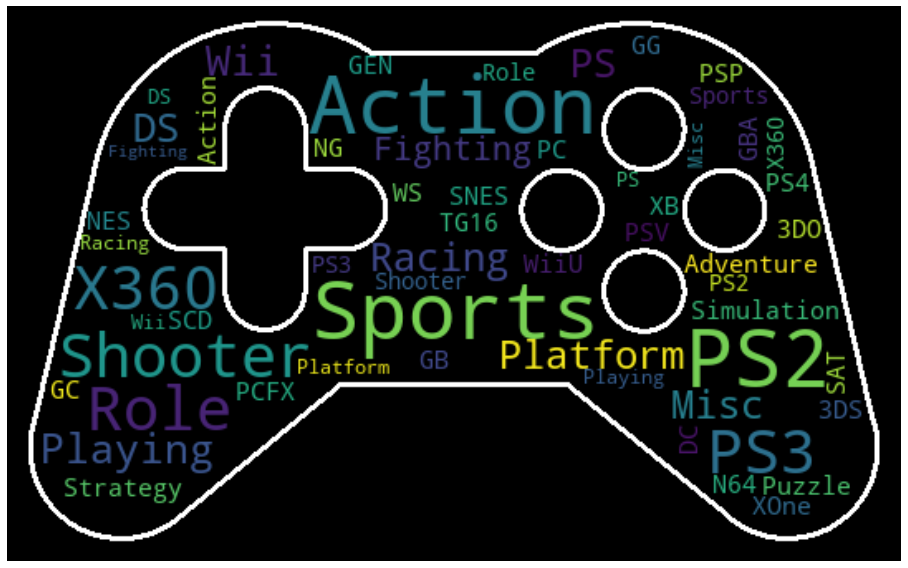

## Table of Contents
* [Import/Installing Modules](#installing-modules)
* [Reading Dataset](#reading-dataset)
* [Missing Values](#missing-values)
* [Data Type](#data-type)
* [Descriptive Statistics](#descriptive-statistics)
* [Word Cloud](#word-cloud)
* [Exploratory Data Analysis (EDA)](#eda)
* [Fast EDA](#fast-eda) - 
    * [Pandas Profiling](#pandas-profiling)
    * [Autoviz](#autoviz)

## Import/Installing Modules <a id="installing-modules"> </a> 

* First we need to install AutoViz to use it in this notebook. 
* Importing all the modules that will be necessary for this notebook. 
* To use shell commands, prefix the command with the ! character.

In [ ]:
!pip install autoviz


import numpy as np
import pandas as pd

import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

from plotly.offline import iplot
import plotly.express as px

from wordcloud import WordCloud
from PIL import Image
import requests
from io import BytesIO
import textwrap

from autoviz.AutoViz_Class import AutoViz_Class
from pandas_profiling import ProfileReport

import warnings
warnings.filterwarnings("ignore") 

sns.set_style('dark')
%matplotlib inline

## Reading Dataset <a id = 'reading-dataset'> </a>

* Reading a comma-separated values(CSV) file into the DataFrame.
* Extracting random samples from data.

In [ ]:
data = pd.read_csv('../input/videogamesales/vgsales.csv', sep = ',')
data.sample(10)

## Missing Values <a id = 'missing-values'> </a>
* Module missingno helps to visualize the distribution of missing values.
* Shape will give the dimensionality of the DataFrame.

In [ ]:
print("Shape: ", data.shape)
msno.matrix(data, labels = True)
plt.show()

* Counting the missing values.
* We have 16598 records in our data. Out of that 271 records are missing from Year and 58 records from Publisher.
* We will drop these records because removing them won't distrub our EDA.

In [ ]:
print("Count of null values:-\n", data.isnull().sum())

In [ ]:
new_data = data.dropna(axis = 0, inplace = False)
new_data = new_data.drop(data[data['Year'] >= 2017].index)

> ## Data type <a id = 'data-type'> </a>
* Checking data types will help us understand how the data is stored and how to manipulate it further.
* Year is stored as float64. We can also change it to int64.

In [ ]:
print("Data types:-\n", new_data.dtypes)
print("Shape: ", new_data.shape)
new_data['Year'] = new_data['Year'].astype('int')

## Descriptive Statistics <a id = 'descriptive-statistics'> </a>
*  Describe gives descriptive statistics of data distribution.
    * count
    * mean
    * minimun, maximum values
    * lower, 50, upper percentiles.
* It excludes NaN values and categorical columns.

In [ ]:
new_data.describe().transpose()

## Word Cloud <a id = 'word-cloud'></a>
* Before starting EDA, lets make a World Cloud.
* First we open the image and use this image as a mask.
* We will crop this image so that only controller is visible and unused white space is removed.
* Change format of the image so that Word Cloud can work properly.
* Prepare the data to fill in the World Cloud. We will only show Platform and Genre names. To make sure that platforms and genres who have more global sales have bigger name in World Cloud, then those who have less global sales, we sort the data before feeding it to World Cloud.

In [ ]:
response = requests.get('https://mpng.subpng.com/20180915/jzo/kisspng-computer-icons-bird-hunt-lite-game-controllers-sca-5b9d77bf746252.7340208815370464634767.jpg')
image = Image.open(BytesIO(response.content))
crop_image = image.crop(box = (180, 90, 720, 425))  
controller_mask = np.array(crop_image)

for i in range(len(controller_mask)):
    for j in range(len(controller_mask[i])):
        for k in range(3):
            if controller_mask[i][j][k] <= 50:
                controller_mask[i][j][k] = 0
            else:
                controller_mask[i][j][k] = 255

wordcloud_data = pd.concat([new_data.groupby('Platform').sum(), 
                            new_data.groupby('Genre').sum()])
wordcloud_data = wordcloud_data['Global_Sales'].sort_values(ascending = False).index

plt.figure(figsize = (15, 8))
wordcloud = WordCloud(background_color = 'black', repeat = True, 
                      max_words = 100, mask = controller_mask, 
                      contour_color = 'white', contour_width = 3, 
                      min_font_size = 10, 
                      max_font_size = 150).generate(' '.join(wordcloud_data))

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()

## Exploratory Data Analysis (EDA) <a id = 'eda'> </a>

In [ ]:
year_data = new_data.groupby(by = 'Year').count()['Rank']
plt.figure(figsize = (15, 8))
plt.plot(year_data.index, year_data.values, marker = 'o', 
         markerfacecolor = 'red', linewidth = 2)
plt.title('Games Released in Each Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.grid(True)
plt.show()

**Inference** - Majority of games were released between year 2006 and 2011.

In [ ]:
def count_plot(column_name, x_text):
    plt.style.use('fivethirtyeight')
    color = ['#4878d0', '#ee854a', '#6acc64', '#d65f5f', '#956cb4', 
             '#8c613c', '#dc7ec0', '#797979', '#d5bb67', '#82c6e2']
    column_data = (new_data.groupby(column_name).count()['Rank']).sort_values(axis = 0)
    
    column_plot = plt.barh(y = column_data.index, width = column_data.values,
                           color = color)
    for bar in column_plot:
        plt.text(bar.get_height() + bar.get_width() + x_text, bar.get_y() + 0.5, 
                 bar.get_width(), horizontalalignment = 'center')
    axes_subplot = plt.subplot()
    axes_subplot.invert_yaxis()
    plt.yticks(column_data.index)
    plt.xticks([])
    plt.title('No. of Games Released On Each %s'%(column_name))
    plt.ylabel(column_name)
    plt.xlabel('No. of games')
    plt.grid(False)

In [ ]:
plt.figure(figsize = (15, 15))
count_plot('Platform', 50)
plt.show()

**Inference** - Most of the games were released on platform PS2 and DS while platform GG and PCFX had least preference.

In [ ]:
plt.figure(figsize = (13, 7))
count_plot('Genre', 85)
plt.show()

**Inference** - Action was the most preferred genre.

In [ ]:
publisher_data = pd.DataFrame(data = new_data.groupby(by = 'Publisher').count()['Rank'])
publisher_data = publisher_data.sort_values(by = 'Rank', ascending = False)
publisher_data = publisher_data.rename(columns = {'Rank' : 'Count'}).head(n = 10)

plt.figure(figsize = (15, 7))
publisher_globalsale_plot = sns.barplot(x = publisher_data.index, 
                                        y = publisher_data.Count, 
                                        edgecolor = 'black', 
                                        linewidth = 2, 
                                        palette = 'colorblind')
publisher_globalsale_plot.set_xticklabels(textwrap.fill(name.get_text(), 
                                                        width = 10) for name in publisher_globalsale_plot.get_xticklabels())
publisher_globalsale_plot.set_xticklabels(publisher_globalsale_plot.get_xticklabels(),
                                          fontdict = {'fontsize' : 12, 'color' : 'black'})
plt.xlabel('Publisher')
plt.ylabel('Sales in Millions')
plt.title('Top 10 Publisher by Global Sales')
plt.grid(False)
plt.show()

**Inference** - Most of the games were published by Electonic Arts.

In [ ]:
year_sales_data = new_data.groupby(by = 'Year')['NA_Sales', 'EU_Sales', 
                                                'JP_Sales', 'Other_Sales', 'Global_Sales'].sum()
plt.figure(figsize = (15, 8))
sns.lineplot(x = year_sales_data.index, 
             y = year_sales_data.iloc[:, 4], 
             color = 'purple', 
             linewidth = 3)
plt.title('Gloabal Sales in Millions')
plt.xlabel('Year')
plt.ylabel('Amount in Millions')
plt.grid(False)
plt.show()

**Inference** - From 2000 to 2009 there was a good increase in sales.

In [ ]:
plt.figure(figsize = (15, 8))
sns.lineplot(x = year_sales_data.index, y = year_sales_data.iloc[:, 0], label = 'North America')
sns.lineplot(x = year_sales_data.index, y = year_sales_data.iloc[:, 1], label = 'Europe')
sns.lineplot(x = year_sales_data.index, y = year_sales_data.iloc[:, 2], label = 'Japan')
sns.lineplot(x = year_sales_data.index, y = year_sales_data.iloc[:, 3], label = 'Other')
plt.title('Sales in Each Year')
plt.xlabel('Year')
plt.ylabel('Amount in Millions')
plt.legend(loc = 2, ncol = 1, shadow = True, fancybox = True, frameon = True)
plt.grid(False)
plt.show()

**Inferences** - 
* North America has the most sales. 
* Around year 2009, North America's sales was twice as much as Europe.

In [ ]:
def first_plot(column_name):
    first_column_data = new_data.groupby(by = column_name)['Year'].min()
    first_column_data = first_column_data.sort_values(axis = 0)
    first_column_plot = sns.stripplot(x = first_column_data.index, 
                                      y = first_column_data.values, palette = 'bright')
    first_column_plot.set_xticklabels(first_column_data.index, 
                                      rotation=45, horizontalalignment='right')
    plt.title('First Game Reales on %s' %(column_name))
    plt.xlabel(column_name)
    plt.ylabel('Year')
    plt.grid(True)
    plt.show() 

In [ ]:
plt.figure(figsize = (15, 8))
first_plot('Platform')

**Inferences** -  
* First game was released on platform 2600.
* There was a gap from year 2006 - 2011 where a new plaform was not tried.

In [ ]:
plt.figure(figsize = (15, 6))
first_plot('Genre')

**Inferences** - 
* As only year is provided, we can say that Shooter, Misc, Fighting, Sports, Action were the first game genres. 
* First Strategy game came in 1991 that is 11 years after the first game was released.

In [ ]:
def type_sales_pie(column_name, sale_name):
    type_sales_data = new_data.groupby(by = column_name)['NA_Sales', 'EU_Sales',
                                                         'JP_Sales', 'Global_Sales']
    type_sales_data = type_sales_data.sum().sort_values(by = 'Global_Sales', 
                                                        ascending = False)
    type_sales_pie = {'data': [{'values': type_sales_data[sale_name], 
                                'labels': type_sales_data.index, 
                                'domain': {'x': [0, .5]}, 
                                'hoverinfo': 'label + percent', 
                                'hole': 0.2, 
                                'type': 'pie'},],
                      'layout': {'title': '%s sales by %s' %(sale_name, column_name), 
                                 'annotations': [{
                                     'font': { 'size': 15}, 
                                     'showarrow': False, 
                                     'text': 'Amount in Millions', 
                                     'x': 0.1, 
                                     'y': 1.1},]}}

    iplot(figure_or_data = type_sales_pie)

In [ ]:
type_sales_pie('Genre', 'NA_Sales')

**Inference** - Major contribution of sales in North America was by Action Genre.

In [ ]:
type_sales_pie('Genre', 'EU_Sales')

**Infernece** - Major contribution of sales in Europe was by Action Genre.

In [ ]:
type_sales_pie('Genre', 'JP_Sales') 

**Infernce** - Major contribution of sales in Japan was by Role-Playing Genre.

In [ ]:
type_sales_pie('Genre', 'Global_Sales')

**Inference** - Globally, most contribution of sales was by Action genre and the least by Strategy games.

In [ ]:
type_sales_pie('Platform', 'NA_Sales')

**Inference** - Major contribution of sales in Europe was by PS3 Platfrom.

In [ ]:
type_sales_pie('Platform', 'EU_Sales')

**Inference** - Major contribution of sales in North America was by X360 Platform.

In [ ]:
type_sales_pie('Platform', 'JP_Sales')

**Inference** - Major contribution of sales in Japan was by DS Platfrom.


In [ ]:
type_sales_pie('Platform', 'Global_Sales')

**Inference** - Globally, most contribution of sales was by PS2 Platfrom and the least by PCFX Platfrom.

In [ ]:
no_sales_platform = new_data.groupby(by = 'Platform')['NA_Sales', 'EU_Sales', 
                                                      'JP_Sales', 'Other_Sales', 'Global_Sales']
no_sales_platform = no_sales_platform.sum().sort_values(by = 'Global_Sales', 
                                                        ascending = True).head(n = 10)
no_sales_platform

**Inference** - PCFX, GG, 3DO, TG16, WS and NG platforms made contributions only in Japan.

In [ ]:
platform_genre_data = new_data.groupby(by = ['Platform', 'Genre']).size()
platform_genre_data = platform_genre_data.reset_index().rename(columns = {0: "Count"})

fig = px.scatter(platform_genre_data, x = 'Platform', y = 'Genre', 
                 size = 'Count', color = 'Count')
fig.show()

**Inferences** - 
* On PS2 platform mostly Action and Sports genre were released.
* On DS platform mostly Misc and Action genre were released.
* On PS3 platform moslty Action genre was released.

In [ ]:
def globalsale_data(column_name):
    column_globalsale_data = new_data.groupby(by = column_name)['Global_Sales']
    column_globalsale_data = column_globalsale_data.sum().sort_values(ascending = False).head(n = 10)
    
    plt.figure(figsize = (15, 7))
    name_globalsale_plot = sns.barplot(x = column_globalsale_data.index, 
                                       y = column_globalsale_data.values, 
                                       edgecolor = 'black', 
                                       linewidth = 2, 
                                       palette = 'colorblind')
    name_globalsale_plot.set_xticklabels(textwrap.fill(name.get_text(), width = 10) for name in name_globalsale_plot.get_xticklabels())
    name_globalsale_plot.set_xticklabels(name_globalsale_plot.get_xticklabels(), 
                                         fontdict = {'fontsize' : 12, 'color' : 'black'})
    plt.ylabel('Sales in Millions')
    plt.grid(False)

In [ ]:
globalsale_data('Name')
plt.title('Top 10 Games by Global Sales')
plt.xlabel('Game')
plt.show()

**Inference** - Wii Sports and GTA V are the most selling games in the world.

In [ ]:
globalsale_data('Publisher')
plt.title('Top 10 Publisher by Global Sales')
plt.xlabel('Publisher')
plt.show()

**Inference** - Nintendo platform has highest sales.

In [ ]:
name_count_data = pd.pivot_table(new_data, index = ['Name'],
                                 aggfunc = {'Name': 'count', 'Global_Sales' : np.sum})
name_count_data = name_count_data.rename(columns = {'Name' : 'Count'})
name_count_data = name_count_data.sort_values(by = ['Count', 'Global_Sales'], 
                                              ascending = False)['Count'].head(n = 10)

plt.figure(figsize = (15, 7))
name_globalsale_plot = sns.barplot(x = name_count_data.index, 
                                   y = name_count_data.values, 
                                   edgecolor = 'black', 
                                   linewidth = 2, 
                                   palette = 'colorblind')
name_globalsale_plot.set_xticklabels(textwrap.fill(name.get_text(), width = 10) for name in name_globalsale_plot.get_xticklabels())
name_globalsale_plot.set_xticklabels(name_globalsale_plot.get_xticklabels(), 
                                     fontdict = {'fontsize' : 12, 'color' : 'black'})
plt.xlabel('Game')
plt.ylabel('Count')
plt.title('Top 10 Games released on different platforms')
plt.grid(False)
plt.show()

**Inference** - Need for Speed: Most Wanted was the only game that was released on 12 different platforms.

In [ ]:
plt.figure(figsize = (8, 8))
cmap = sns.diverging_palette(250, 230, 90, 60, as_cmap=True)
sns.heatmap(data = new_data.corr(), annot = True, cmap = cmap, 
            linewidths = 2, square = True, 
            linecolor = 'White', fmt = '.2f')
plt.title('Correlation \n', fontdict = {'fontsize': 20,  
                                        'fontweight' : 'normal',
                                        'color' : 'black'})
plt.show()

## Fast EDA <a id = 'fast-eda'> </a>
* There are many methods by which EDA can be done fast.
* This will save our time and can do more detailed analysis.
* Here, we will use untampered data.
* We will see only 2 modules by which we can achieve fast EDA.
* Some modules by which we can do fast EDA in python are as follows -
    * AutoViz
    * DataPrep
    * Dora
    * Edaviz
    * ExploriPy
    * HoloViews
    * Lens
    * Pandas-profiling
    * Pandas-summary
    * SpeedML
    * StatsModels
    * Sweetviz
    * Tpot

### 1. Pandas Profiling <a id = 'pandas-profiling'> </a>

In [ ]:
ProfileReport(data)

### 2. Autoviz <a id = 'autoviz'> </a> 

In [ ]:
AV = AutoViz_Class()
df = AV.AutoViz(filename = '../input/videogamesales/vgsales.csv', 
                sep = ',', chart_format = 'svg', verbose = 2)

In [ ]:
from IPython.display import HTML
style = "<style> div.changeh { background-color: #FF5733; width: 350px; height: 40px;} </style>"
HTML(style)

#### If you found this notebook useful then upvote it.
#### If found any error or a new approach to the problem then mention it in the comments section.